In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection # Scikit-learn (sklearn)

import torch
from torch import nn # PyTorch's building blocks for neural networks
from torchmetrics import Accuracy

torch.__version__

'2.1.0'

<br>

## 1. Data loading & preprocessing

In [2]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
del titanic_df['Cabin'] # 너무 많은 결측치가 존재
del titanic_df['PassengerId'] # Passenger 번호는 큰 의미를 갖고있지 않은 일련번호
del titanic_df['Ticket'] # ticket 번호에서 패턴이 확인되지 않음


titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name'] # 호칭만 남김

rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)


sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)


titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)


titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4


titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


<br>

## 2. Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [4]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [5]:
X = torch.tensor(np.array(titanic_data)).type(torch.float)
y = torch.tensor(np.array(titanic_target)).type(torch.LongTensor) # IntTensor == Int32 vs LongTensor == Int64

y = y.reshape(-1) # PyTorch 기반 classification에서는 label을 1차원 배열 형태로 준비

In [6]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(X, y,
                                                                                  test_size=0.3,
                                                                                  random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

torch.Size([623, 8])
torch.Size([268, 8])
torch.Size([623])
torch.Size([268])


<br>

## 3. Build & Train the model 

<br>
<br>

### 1) Build the model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [9]:
class MLP_Classifier(nn.Module): # should inherit the class nn.Module
    
    
    def __init__(self, num_features, num_classes, num_nodes=256):
        
        super().__init__()
        
        self.sequential_stack = nn.Sequential( # Sequential-stack
            nn.Linear(in_features=num_features, out_features=num_nodes),
            # nn.BatchNorm1d(num_nodes),
            nn.ELU(), # use "ELU"
            nn.Linear(in_features=num_nodes, out_features=num_nodes * 2),
            nn.ELU(), # use "ELU"
            nn.Linear(in_features=num_nodes * 2, out_features=num_nodes * 2),
            nn.ELU(), # use "ELU"
            nn.Linear(in_features=num_nodes * 2, out_features=num_nodes),
            nn.ELU(), # use "ELU"
            nn.Dropout(0.5), # Drop-out
            nn.Linear(in_features=num_nodes, out_features=num_classes),
            # We don't need to use nn.Softmax() (check the following source codes)
        )
    
    def forward(self, x): # forward-pass
        
        return self.sequential_stack(x)

<br>
<br>

### 2) Check the model

In [11]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = MLP_Classifier(num_features=8, 
                       num_classes=2, 
                       num_nodes=256).to(device)

In [12]:
# 모델을 evaluation mode로 설정
model.eval()

with torch.inference_mode(): # Set "inference mode"
    
    # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    untrained_logits = model(test_data.to(device)) # 모델 & 데이터는 동일한 디바이스 위에 위치해있어야 함
    
print(untrained_logits[:10])

tensor([[ 0.0386, -0.1033],
        [ 0.0287, -0.1151],
        [ 0.0279, -0.0357],
        [ 0.0051, -0.1376],
        [ 0.0441, -0.1176],
        [ 0.0258, -0.1491],
        [-0.0019, -0.1038],
        [-0.0241, -0.0874],
        [ 0.0134, -0.1174],
        [ 0.0624, -0.1300]])


<br>
<br>

### 3) Train the model

In [13]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = MLP_Classifier(num_features=8, 
                       num_classes=2, 
                       num_nodes=256).to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# loss_fn = nn.BCEWithLogitsLoss() # Binary Cross-entropy + built-in Sigmoid (accepting "logits")

optimizer = torch.optim.Adam(params=model.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.001) # "l"earning "r"ate 

metric_accuracy = Accuracy(task='binary').to(device) # from torchmetrics import Accuracy

In [17]:
torch.manual_seed(42)


train_data, train_label = train_data.to(device), train_label.to(device)
test_data, test_label   = test_data.to(device), test_label.to(device)
 
    
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []

for epoch in range(20):
    
    # 모델을 training mode로 설정 (default state)
    model.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    logits = model(train_data)
    y_predicted = logits.softmax(dim=1).argmax(dim=1) # logits -> predicted probabilities -> predicted class numbers

    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(logits, train_label) # <- nn.CrossEntropyLoss() : built-in Softmax
    loss_train_list.append(loss_train.item())
    
    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits_test = model(test_data)
        y_predicted_test = logits_test.softmax(dim=1).argmax(dim=1)
        
        # Test cost 계산
        loss_test = loss_fn(logits_test, test_label)
        loss_test_list.append(loss_test.item())
        

    acc_train = metric_accuracy(y_predicted, train_label) 
    acc_train_list.append(acc_train.item())
    
    acc_test  = metric_accuracy(y_predicted_test, test_label)
    acc_test_list.append(acc_test.item())
    
    print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 0.42435, Acc: 0.81% | Test loss: 0.41267, Test acc: 0.80%
Epoch: 1 | Loss: 0.41375, Acc: 0.82% | Test loss: 0.41196, Test acc: 0.81%
Epoch: 2 | Loss: 0.41905, Acc: 0.81% | Test loss: 0.41176, Test acc: 0.81%
Epoch: 3 | Loss: 0.41063, Acc: 0.82% | Test loss: 0.41483, Test acc: 0.81%
Epoch: 4 | Loss: 0.41766, Acc: 0.81% | Test loss: 0.41716, Test acc: 0.80%
Epoch: 5 | Loss: 0.41223, Acc: 0.81% | Test loss: 0.41205, Test acc: 0.81%
Epoch: 6 | Loss: 0.40345, Acc: 0.82% | Test loss: 0.40910, Test acc: 0.81%
Epoch: 7 | Loss: 0.41651, Acc: 0.81% | Test loss: 0.40866, Test acc: 0.81%
Epoch: 8 | Loss: 0.40800, Acc: 0.82% | Test loss: 0.41036, Test acc: 0.81%
Epoch: 9 | Loss: 0.40027, Acc: 0.82% | Test loss: 0.41262, Test acc: 0.81%
Epoch: 10 | Loss: 0.40985, Acc: 0.83% | Test loss: 0.40757, Test acc: 0.82%
Epoch: 11 | Loss: 0.41135, Acc: 0.81% | Test loss: 0.40479, Test acc: 0.81%
Epoch: 12 | Loss: 0.39925, Acc: 0.83% | Test loss: 0.40503, Test acc: 0.81%
Epoch: 13 | Loss: 0.40

<br>

## 4. Test the model 

In [18]:
# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    logits = model(test_data.to(device))
    y_predicted = torch.softmax(logits, dim=1).argmax(dim=1) #  logits -> predicted probs -> predicted class nums

acc_test = metric_accuracy(y_predicted, test_label.to(device)) 

print('Test accuracy : {} %'.format(acc_test))

Test accuracy : 0.8171641826629639 %


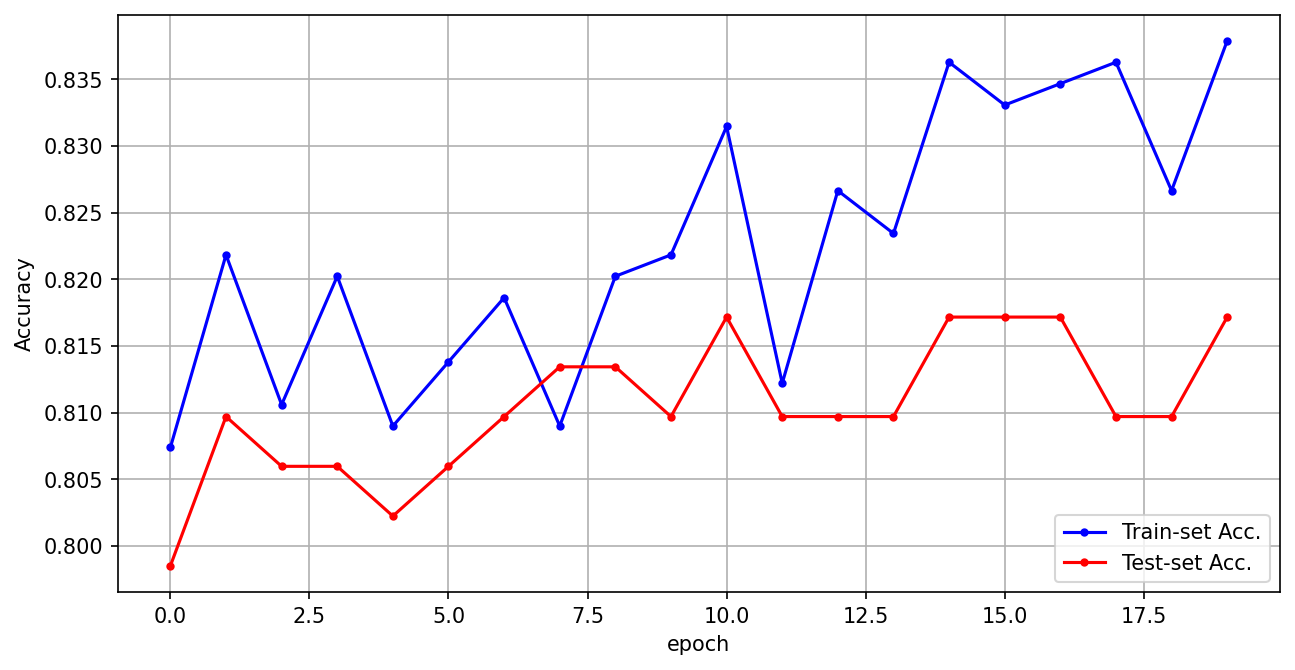

In [20]:
epochs = np.arange(len(loss_train_list)) # array of range

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs, acc_train_list, marker='.', c='blue', label="Train-set Acc.")
plt.plot(epochs, acc_test_list, marker='.', c='red', label="Test-set Acc.")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

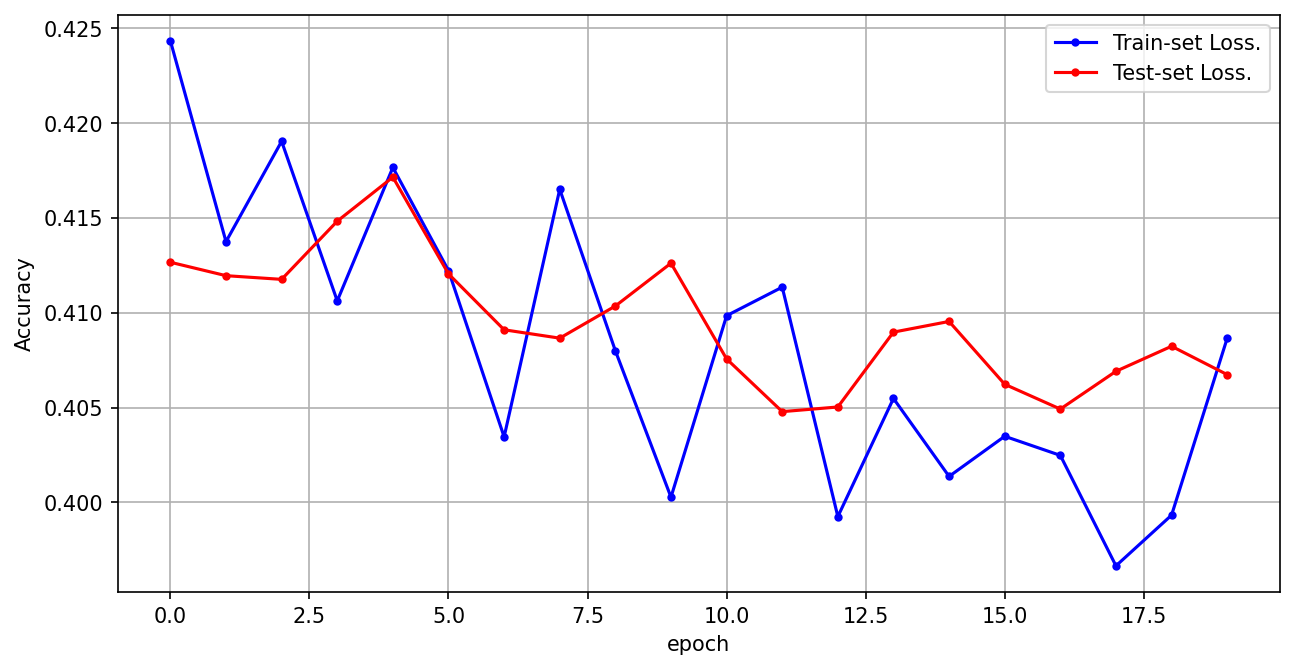

In [19]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs, loss_train_list, marker='.', c='blue', label="Train-set Loss.")
plt.plot(epochs, loss_test_list, marker='.', c='red', label="Test-set Loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [21]:
sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]])
data_tensor = torch.tensor(sample_data).type(torch.float)


# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    logits = model(data_tensor.to(device))
    y_probs = logits.softmax(dim=1)
    y_predicted = logits.softmax(dim=1).argmax(dim=1) #  logits -> predicted probs -> predicted class nums


print(logits)
print(y_probs)
print(y_predicted)
print(['Not survived', 'Survived'][y_predicted])

tensor([[ 0.7345, -0.4931]])
tensor([[0.7734, 0.2266]])
tensor([0])
Not survived


<br>

## 5. Save the model 

<br>

#### * 모델을 통째로 저장하고 불러오는 것도 가능 @ https://pytorch.org/tutorials/beginner/saving_loading_models.html

#### -> **torch.save(model, PATH)** & **model = torch.load(PATH)**

In [22]:
# Shorter version

torch.save(obj=model.state_dict(), # only parameters
           f='models/usethis_classifier.pth')

In [55]:
# # Longer version (디렉토리부터 생성)


# # 1. 모델 파라미터 파일 저장을 위한 디렉토리 생성 (os.mkdir 함수로 대체하여 사용 가능)

# from pathlib import Path
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)
# # parents=True : any missing parents of this path are created as needed.
# # exist_ok=True : FileExistsError exceptions will be ignored.


# # 2. 모델 파라미터 저장경로 지정 

# MODEL_NAME = "usethis_classifier.pth" # common convention for PyTorch saved models or objects : .pt or .pth
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # WindowsPath('models/usethis_classifier.pth')


# # 3. 모델 파라미터 저장

# print('Saving model to :', MODEL_SAVE_PATH)

# torch.save(obj=model.state_dict(), # only parameters
#            f=MODEL_SAVE_PATH)

In [24]:
loaded_model = MLP_Classifier(num_features=8, 
                              num_classes=2, 
                              num_nodes=256) # 모델 구조 생성 

loaded_model.load_state_dict(torch.load(f='models/usethis_classifier.pth')) 
# pickle 파일을 먼저 load 후 paramter 값들을 꺼내어 모델로 load

loaded_model.to(device)

MLP_Classifier(
  (sequential_stack): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [25]:
# 1. 모델을 evaluation mode로 설정
loaded_model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    logits = loaded_model(test_data.to(device))
    y_predicted = torch.softmax(logits, dim=1).argmax(dim=1) #  logits -> predicted probs -> predicted class nums

acc_test = metric_accuracy(y_predicted, test_label.to(device)) 

print('Test accuracy : {} %'.format(acc_test))

Test accuracy : 0.8171641826629639 %
